# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [6]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [312]:
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
I plan to use a dataset on web fictions that I scarped from a web fiction website. This is one of the largest websites publishing web fictions. The website has a branch for male and female audience, respectively. Using a “most bookmarked” ranking board, I scraped the first 30 chapters of the 500 most popular books on the male and the female version of the website, which gave me in total 1000 novels. I consider to explore two research questions using this dataset. 

**First**, what are the emotions elicited by these novels? How do the emotions differ for the novel targeting male audience and the novel targeting female audience?  

**Second**, how are male and female characters portrayed in these two kinds of novels?

## ***Why?***
Successfully web fictions can turn into physical books and TV series. For example, one of the web fictions in the current dataset was the story basis of the most popular TV series in China in 2016 (lang ya bang/Nirvana in fire). Reading web fictions is a mainstream, rather than a minority, hobby. Since web fictions is an important entrainment source of the contemporary Chinese people, examining characteristics of web fictions may help to reveal the popular taste and preference. I wish that the research question focusing on emotions will help me understand how people resonate with these stories and why people are attracted to web fictions; I wish the research question focusing on male/female characters help me understand what are the ideal or stereotypical figures of man and woman. 

Although I only have the first 30 chapters, I consider the beginning of the novel to be the most important part. Because the website charges readers for latter chapters, the beginning are crucial for determining if the novel can be lucrative. If readers do not get interested in the novel after reading the first 30 chapters, the chance of them continuing is slim. 

## ***How?***
My analysis heavily relies on a Chinese tokenizing package “jieba”. I also use “jieba”’s POS tag function to determine the word attributes. 

**RQ 1**: What are the emotions elicited? For this question, I rely on a Chinese sentiment dictionary developed by Dalian University of Technology. I have to admit that I am not sure how reliable this dictionary is. This dictionary categories Chinese words into 21 emotions, corresponding to happy, assured, respect, praise, believe, like, wish, anger, sad, disappoint, guilt, miss, panic, fear, ashamed, annoyed, hate, blame, jealous, suspect, and surprise. The dictionary also gives an intensity score for each word. For the 30 chapter of the 1000 novel, I constructed a score for the 21 emotions by summing up the intensity value of all the words that belong to each of the 21 emotions. This gives me a 3000 * 21 matrix (because each book corresponds to 30 chapters/rows). 

I have not decided how to proceed. But what I am thinking right now is to first simply take averages of each emotion to first see which emotions are salient. Then I may look for co-occurrence of emotions. 

**RQ 2**: How are male and female character portrayed?
For this question, I use word-embedding to look for the context of “he” and “she”. When I build the model, I will include all words to maintain the structure of the data. But I am mainly interested in the adjective and verbs used to portray “he” and “she”, so when I look at the outcomes, I ignore most of the nouns. 

So far, the impression I got from the word embedding is that male and female novels indeed portray “he” and “she” differently. I will also try to validate this intuition using classification models. I plan to screen the novel content by only keeping the windows next to “he” and “she”, then I will try to classify the novels based only on the “he”/“she”-related content to see if I can replicate the male and female label.  


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
I have the first 30 chapters of the most popular 1000 novels on the largest web fiction websites. The pros are that these are the most successful novels and they have a large audience coverage. Although I only have a small sample in comparison to the massive amount of web fictions available, these elite novels tell a lot about the popular public taste. However, having a very selective sample also mean that the results will probably not make a good generalization to other novels. For example, some genres (e.g., Anime, Comic, & Games, ACG) are present but not well represented in this dataset. 

For a better work on this topic, I would need a larger sample that covers more than one website and include novels of various popularity. A larger sample allow me to better understand what are the popular genres and why. For example, although there are only a few ACG novels in my dataset, not making the most popular 1000 books does not necessarily mean that this genre is unpopular. Similarly, it would be interesting to systematically compare the popular novels with the unpopular ones, but this require much more work because it is difficult to access to unpopular one. 

My analysis focuses on novels. I treated them as a window into people’s taste and perception. Yet, since what I am interested is people eventually, I need to be very careful with my inferences. Even though I know web fictions is popular in general, I do not know how many people are actually reading them and what are the demographic composition. I know that these novels have a large audience base, but the number is still negligible in comparison to the Chinese population. I think an unescapable limitation is that I do not sufficient information on web fictions in genearl.


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

<span style="color:green"> Flast clustering does not really give me meaningful results for my dataset. But assuming that it does, I would give a name to each of the cluster depending the top words describing each cluster. Then I will ask MTurk workers to categorize each of novel into one of the clusters.

In [296]:
bookDF_male_tokenized= pandas.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pandas.read_pickle("bookDF_female_tokenized.pickle")

In [ ]:
dalian= pandas.read_excel("dalian_sentiment_word.xlsx", encoding="latin-1")
print(dalian.columns)

In [302]:
#Clustering of the novels based on the adjectives of the novel introduction 
#I filter out only the words that are included in the dalian dictionary's adjectives,
#becuase these are the adjectives that contain emotional meaning 

dalian_words= []
for i in range(dalian.shape[0]):
    if (dalian['词性种类'].iloc[i] not in ["noun", "verb", "adv", "idiom", "nw", "prep"]) & \
       (dalian["极性"].iloc[i] in [1, 2]):
        dalian_words+= [dalian['词语'].iloc[i]]
dalian_words= set(dalian_words)
print(len(dalian_words))

helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_intro= pandas.concat([bookDF_male_tokenized["intro_clean"], bookDF_female_tokenized["intro_clean"]], axis= 0)


helper_lis_dalian= []
for cell in bookDF_intro:
    cell_dalian= [w for w in cell if w in dalian_words]
    helper_lis_dalian+= [cell_dalian]
    

helper_str= []
for i in range(bookDF_ch.shape[0]):
    helper_str+= [" ".join(helper_lis_dalian[i])]

all_ch_string_DF= pandas.DataFrame({"all_ch_string": helper_str})


4119


In [328]:
my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3)
novel_tf_vects= my_tf_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
print(novel_tf_vects.shape)

clusterer = sklearn.cluster.KMeans(n_clusters= 4, random_state=10)
cluster_labels = clusterer.fit_predict(novel_tf_vects)
print(cluster_labels.shape)
cluster_DF= pandas.DataFrame(cluster_labels, columns= ["cluster"])

(1000, 165)
(1000,)


In [352]:
intro_DF= pandas.DataFrame({"intro": pandas.concat([bookDF_male_tokenized["intro"], 
                                           bookDF_female_tokenized["intro"]], 
                                           ignore_index= True, axis= 0)})

MT_DF= pandas.concat([intro_DF["intro"], cluster_DF["cluster"]], axis= 1)
MT_DF[5:10]

,intro,cluster
5,某天，宋书航意外加入了一个仙侠中二病资深患者的交流群，里面的群友们都以‘道友’相称，群名片都...,0
6,这里是属于斗气的世界，没有花俏艳丽的魔法，有的，仅仅是繁衍到巅峰的斗气！ 新书等级制度：斗...,0
7,郑重申明：此书系古典仙侠作品，纯属虚构，与历史无关！！ 太坑爹了，居然穿越到一个马上就要砍...,0
8,在夏族的安阳行省，有一个很小很不起眼的领地，叫——雪鹰领！ 故事，就从这里开始！ ** ...,0
9,伴随着魂导科技的进步，斗罗大陆上的人类征服了海洋，又发现了两片大陆。魂兽也随着人类魂师的猎杀...,1


<span style="color:green"> The cluster_labels variable above assign each novel introduction to a cluster. Appending these labels next to the book introductions. I have the dataset ready for MTurk. (I can randomize this dataset and randomly sample a part)

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [9]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [16]:
print(anno.annotations.shape)
anno.annotations

(800, 8)


array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [11]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [12]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [18]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


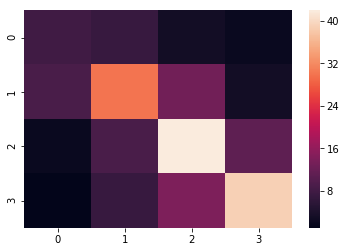

In [19]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [28]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [21]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [29]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [32]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [36]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
#Cohens_kappa is just a parameter indicating what kind of reliability I want to calculate
m

array([[1.        , 0.43917037, 0.47677621,        nan,        nan,
               nan, 0.45819119, 0.43381462],
       [0.43917037, 1.        , 0.38432922, 0.41344423,        nan,
               nan,        nan, 0.33643611],
       [0.47677621, 0.38432922, 1.        , 0.39583333, 0.51704894,
               nan,        nan,        nan],
       [       nan, 0.41344423, 0.39583333, 1.        , 0.34597068,
        0.4446844 ,        nan,        nan],
       [       nan,        nan, 0.51704894, 0.34597068, 1.        ,
        0.37938644, 0.43039733,        nan],
       [       nan,        nan,        nan, 0.4446844 , 0.37938644,
        1.        , 0.38341929, 0.31214748],
       [0.45819119,        nan,        nan,        nan, 0.43039733,
        0.38341929, 1.        , 0.394806  ],
       [0.43381462, 0.33643611,        nan,        nan,        nan,
        0.31214748, 0.394806  , 1.        ]])

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


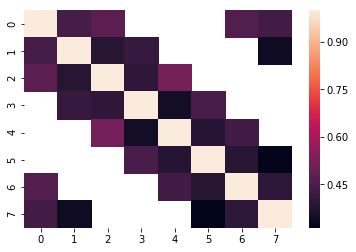

In [33]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [37]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [38]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [39]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


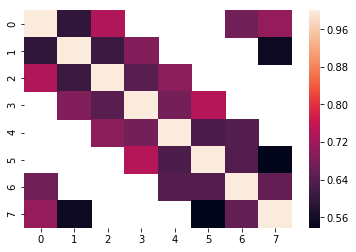

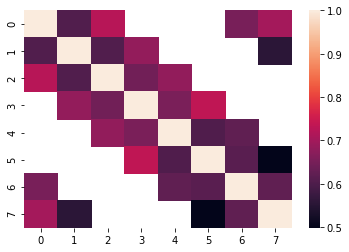

In [40]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [41]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

<span style="color:green"> **The task I set up**: I show workers the short introduction of my novel (only several sentences), and I ask them to evaluate whether the novel was written for male audience, for female audience, or for both. **Sample**: I uploaded 500 book introductions for the workers to categorize. I used systematical sampling by ranking the novels by popularity (male and female novels separately), and then sample every two novels. But I only got back the categorization results of 319 novels. 
**Rationale**: A large part of my analysis rely on the fact that novels target on male and female audience separately. The web fiction website indeed present the novels on the male and female verions of the website separately. But I do not know why the website make the separation and if the separation is valid. I set up this task to validate the gender separation. 

<span style="color:green">Unfortunately, I started MTurk before reading the instructions... I chose the wrong mode of MTurk, which only allowed me to choose whether I want one or two workers to work my task.  

<span style="color:green">I noticed two **problems** that make MTurk not suitable for my purpose. 

    First, MTurk does not have Chinese workers. It has a place where I can choose "location", but "China" turns out to be an invalid option. I worked around this by inclding "(Chinese task 中文任务!)" in the title of my project and hope that only people who can read Chinese click into it, but there is really no guarantee. 

    Second, I think my task is too complicated for MTurk. When I look at the result, it sometiems makes no sense why workers categorized the novels in that way.  

<span style="color:green">I find it hard to accept the workers' results becuase, in my opinion, whether the novel belong to male novels or female novels is quite obvious. But the workers not only have a low inter-coder reliability, but also differ from the true tag. To varify my intuition that the novels are genderly separatable, I hand code 319 novels myself (319 is the size of the results I download from MTurk, even though I provided 500 tasks). I have never read these novels before, so even though I work on this dataset, I do not know  their true category. I spent 40 minutes categorizing 319 novels while listening to music. I tried to do it as fast and as unattentive as I can to imitate what workers would probably do. 

<span style="color:green">For the 319 novels I categorize, 290 of them correctly correspond to the true categories, which gives me a 91% accuracy rate. Of course, I went in the categorization task with my bias/stereotype. But I just want to demonstrate that if a person has an idea about what girls and boys read, it is possible to separate the novels. 

<span style="color:green">Because I really felt skeptical about the workers' results, I will not use the MTurk results other than for this week's exercise. 

In [69]:
workers_results= pandas.read_csv("Batch_3101663_batch_results.csv")
workers_results["intro"].to_csv("my_work.csv")
my_results= pandas.read_csv("my_answer.csv")
combined_results= pandas.concat([workers_results, my_results], axis= 1)
correct= 0

for i in range(combined_results.shape[0]):
    if combined_results.iloc[i]["gender"]== combined_results.iloc[i]["g"]:
        correct+= 1
        
print("the accuracy rate of my categorization is: ", correct/combined_results.shape[0])
    

the accuracy rate of my categorization is:  0.9090909090909091


<span style="color:green">I have in total 7 workers worked on my task, but one worked on 1 task,  one worked on 15 tasks, and one worked on 22 tasks. Only 4 worked on a reasonable amount of the tasks. 

<span style="color:green">For continuing this exercise, I found the two workers who overlaped the most. Together with my hand coding, for each novel I have 3 votes.

In [224]:
worker1= combined_results["Worker1"]
worker2= combined_results["Worker2"]
worker= list(worker1.append(worker2))
worker_dic= {}
for w in worker:
    if w not in worker_dic:
        worker_dic[w]= 1
    else:
        worker_dic[w]+= 1
print(worker_dic)

worker_index_dic= {}
ind= 0
for w in worker_dic.keys():
    worker_index_dic[w]= ind
    ind+= 1
print(worker_index_dic)

ex_np= np.full((319, 7), -1)
for i in range(combined_results["Worker1"].shape[0]):
    worker= combined_results["Worker1"][i]
    answer= combined_results["Answer1"][i]
    if answer== "女性读者":
        ex_np[i, worker_index_dic[worker]]= 0
    elif answer== "男性读者":
        ex_np[i, worker_index_dic[worker]]= 2
    elif answer== "男、女读者都可以":
        ex_np[i, worker_index_dic[worker]]= 1
    
for i in range(combined_results["Worker2"].shape[0]):
    worker= combined_results["Worker2"][i]
    answer= combined_results["Answer2"][i]
    if answer== "女性读者":
        ex_np[i, worker_index_dic[worker]]= 0
    elif answer== "男性读者":
        ex_np[i, worker_index_dic[worker]]= 2
    elif answer== "男、女读者都可以":
        ex_np[i, worker_index_dic[worker]]= 1

my_np= np.empty((319, 1))
for i in range(combined_results["g"].shape[0]):
    if combined_results["g"][i]== "female": 
        my_np[i, 0]= 0
    elif combined_results["g"][i]== "male": 
        my_np[i, 0]= 2
        
ex_np= np.concatenate((ex_np, my_np), axis= 1)
print(ex_np.shape)

#Double check which two workers have the most overlaping tasks. 
worker_worker= []
for i in range(combined_results.shape[0]):
    worker_worker+= [set([combined_results.iloc[i]["Worker1"], 
                          combined_results.iloc[i]["Worker2"]])]

print(worker_worker.count(set(['A2NJTYYY37DNO', 'A3GLMBZSG3VU4P'])))
print(worker_worker.count(set(['A2NJTYYY37DNO', 'A8TIL9U6YHG5'])))
print(worker_worker.count(set(['A3GLMBZSG3VU4P', 'A8TIL9U6YHG5'])))
  

{'A2R2YZTSME1K3F': 65, 'A1X94LTZZQMHTP': 15, 'A2NJTYYY37DNO': 105, 'A8TIL9U6YHG5': 305, 'A2WGW5Y3ZFBDEC': 22, 'AKSJ3C5O3V9RB': 1, 'A3GLMBZSG3VU4P': 125}
{'A2R2YZTSME1K3F': 0, 'A1X94LTZZQMHTP': 1, 'A2NJTYYY37DNO': 2, 'A8TIL9U6YHG5': 3, 'A2WGW5Y3ZFBDEC': 4, 'AKSJ3C5O3V9RB': 5, 'A3GLMBZSG3VU4P': 6}
(319, 8)
7
93
117


<span style="color:green"> The heatmap below shows the agreement between the two workers that have the most overlaping tasks (117 overlaps between 'A3GLMBZSG3VU4P' and 'A8TIL9U6YHG5'). I do not worry too much about the disagreement between 0 (female) and 1 (both genders), and between 1 (both genders) and 2 (gender). But it is porblematic that they disagree between 0 (female) and 2 (male) for 25/117 (21%) of the novels...

<span style="color:green"> The agreement scores between the two coders and me are also low. 

[[10. 30. 11.]
 [ 6. 12.  4.]
 [14. 22.  8.]]


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


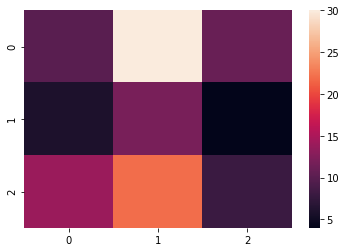

scotts_pi between worker 1 and worker 2:  -0.1246052839103487
scotts_pi between worker 1 and me:  0.03442137199736908
scotts_pi between me and worker 2:  -0.08745047692535007


In [229]:
anno = AnnotationsContainer.from_array(ex_np, missing_values=[-1])
anno.annotations
anno.labels

pyanno.measures.agreement.labels_frequency(anno.annotations,3)
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,3], anno.annotations[:,6], 3)
print(c)
ac = seaborn.heatmap(c)
plt.show()

print("scotts_pi between worker 1 and worker 2: ", 
      scotts_pi(anno.annotations[:,3], anno.annotations[:,6]))
print("scotts_pi between worker 1 and me: ", 
      scotts_pi(anno.annotations[:,3], anno.annotations[:,7]))
print("scotts_pi between me and worker 2: ", 
      scotts_pi(anno.annotations[:,6], anno.annotations[:,7]))

//anaconda/lib/python3.5/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[[ 1.                 nan -0.82242991  0.21464771         nan         nan
   1.          0.5398596 ]
 [        nan  1.          0.23320351 -0.27338009  1.                 nan
          nan -0.26461843]
 [-0.82242991  0.23320351  1.          0.06850373  1.         -1.14285714
   0.0202738  -0.11449897]
 [ 0.21464771 -0.27338009  0.06850373  1.          0.19428434         nan
  -0.0438677   0.05960081]
 [        nan  1.          1.          0.19428434  1.                 nan
          nan  0.4404911 ]
 [        nan         nan -1.14285714         nan         nan         nan
          nan  1.        ]
 [ 1.                 nan  0.0202738  -0.0438677          nan         nan
   1.          0.13002825]
 [ 0.5398596  -0.26461843 -0.11449897  0.05960081  0.4404911   1.
   0.13002825  1.        ]]


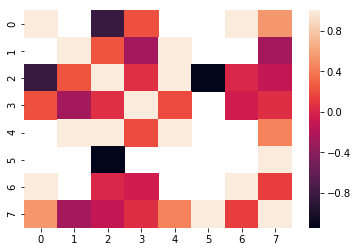

In [230]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
#Cohens_kappa is just a parameter indicating what kind of reliability I want to calculate
print(m)
ax = seaborn.heatmap(m)
plt.show() 

<span style="color:green"> Comparing the block below and the block above: Taking into account that "both gender" is a category in between "female" and "male" increases the aggreement. But the the agreement scores are still low. The improvement is so weak that no color change can be shown on the heatmap. 

weighted cohens between 2 workers:  -0.06737618436261394
averaged weighted cohens:  0.19421013605533224
[[ 1.                 nan -1.05417607  0.24540411         nan         nan
   1.          0.5398596 ]
 [        nan  1.         -0.02073882 -0.30684415  1.                 nan
          nan -0.33528673]
 [-1.05417607 -0.02073882  1.          0.08312184  1.         -0.23529412
   0.07338769 -0.12861602]
 [ 0.24540411 -0.30684415  0.08312184  1.          0.12482737         nan
  -0.06737618  0.07052426]
 [        nan  1.          1.          0.12482737  1.                 nan
          nan  0.50049822]
 [        nan         nan -0.23529412         nan         nan         nan
          nan  1.        ]
 [ 1.                 nan  0.07338769 -0.06737618         nan         nan
   1.          0.20070158]
 [ 0.5398596  -0.33528673 -0.12861602  0.07052426  0.50049822  1.
   0.20070158  1.        ]]


//anaconda/lib/python3.5/site-packages/pyanno/measures/agreement.py:207: RuntimeWarning: invalid value encountered in double_scalars
  kappa = 1. - (weights*observed_freq).sum() / (weights*chance_freq).sum()
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


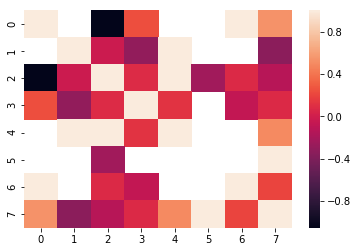

In [232]:
#Considering the distance between labels
print("weighted cohens between 2 workers: ", 
      cohens_weighted_kappa(anno.annotations[:,3], anno.annotations[:,6]))

print("averaged weighted cohens: ", 
      pairwise_metric_average(cohens_weighted_kappa,anno.annotations))

m = pairwise_matrix(cohens_weighted_kappa, anno.annotations)
#Cohens_kappa is just a parameter indicating what kind of reliability I want to calculate
print(m)
ax = seaborn.heatmap(m)
plt.show() 

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

<span style="color:pink"> Shiyu's self note: I do not fully understand what is happening here partially becuase I couldn't find documentation online. 

In [167]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [168]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.22287149e-01 1.29197263e-01 1.48468271e-01 4.73170945e-05]
  [1.66229020e-01 6.05487660e-01 1.45936691e-01 8.23466286e-02]
  [2.49674722e-02 9.98504530e-02 6.41532954e-01 2.33649121e-01]
  [4.31486145e-03 5.89667500e-02 1.15008611e-01 8.21709777e-01]]

 [[6.30018853e-01 2.67793350e-01 9.65579783e-02 5.62981858e-03]
  [2.62767709e-01 4.67875053e-01 2.60096911e-01 9.26032760e-03]
  [6.21304370e-02 1.54625713e-01 6.17328432e-01 1.65915418e-01]
  [3.28561692e-02 1.52923991e-01 7.00960941e-02 7.44123745e-01]]

 [[6.12021944e-01 2.73877211e-01 9.71341507e-02 1.69666938e-02]
  [2.15606882e-01 6.27270960e-01 1.43845818e-01 1.32763402e-02]
  [1.33852502e-01 8.33381885e-02 6.33424045e-01 1.49385265e-01]
  [1.33412557e-01 7.96571363e-02 8.41527702e-02 7.02777537e-01]]

 [[5.70103494e-01 2.11189570e-01 1.55369907e-01 6.33370288e-02]
  [1.01767233e-01 6.22792576e-01 2.10163299e-01 6.52768917e-02]
  [1.30534783e-01 1.37022873e-01 5.37966777e-01 1.94475568e-01]
  [1.17295002e-02 1.64948913e-01 1

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [169]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [172]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [ ]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [175]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [233]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(<matplotlib.figure.Figure at 0x1164cf198>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x116c394e0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x116a70f98>))

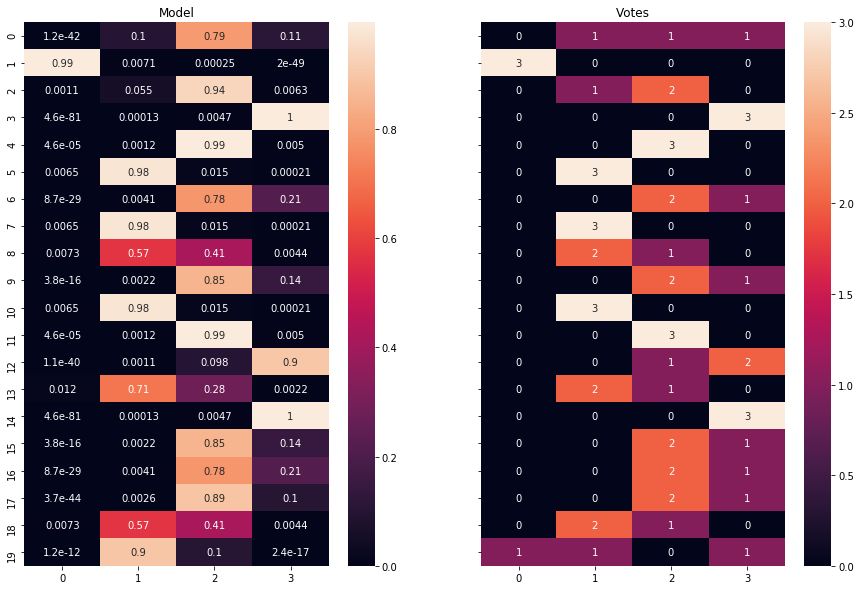

In [177]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [178]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.89676154 0.70058935 0.76939003 0.64810318 0.92999384 0.83641174
 0.86264447 0.64651277]
-3045.100724698742


In [179]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79130321 0.74077431 0.76221296 0.72516389 0.71640597 0.71856097
 0.77316049 0.71662039]
-2811.945979164713


In [180]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.79068285, 0.7076767 , 0.80195913, ..., 0.7293533 , 0.8103993 ,
        0.70205013],
       [0.78732347, 0.75235136, 0.74322345, ..., 0.75676728, 0.74787121,
        0.742585  ],
       [0.78732347, 0.75235136, 0.74322345, ..., 0.75676728, 0.74787121,
        0.742585  ],
       ...,
       [0.84328599, 0.73747085, 0.68787694, ..., 0.66307391, 0.75449093,
        0.68478002],
       [0.80204449, 0.73056654, 0.69389636, ..., 0.63270743, 0.80907993,
        0.67688705],
       [0.80204449, 0.73056654, 0.69389636, ..., 0.63270743, 0.80907993,
        0.67688705]])

In [181]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110552 0.28932944 0.36503918 0.33452585]
 [0.99022502 0.00241853 0.00404873 0.00330772]
 [0.00249968 0.05505522 0.93461504 0.00783006]
 ...
 [0.00252907 0.0439448  0.94560401 0.00792213]
 [0.00249408 0.00571237 0.93252367 0.05926988]
 [0.03188927 0.93882718 0.01611663 0.01316692]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(<matplotlib.figure.Figure at 0x116d97128>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x116511f98>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1164bb2e8>))

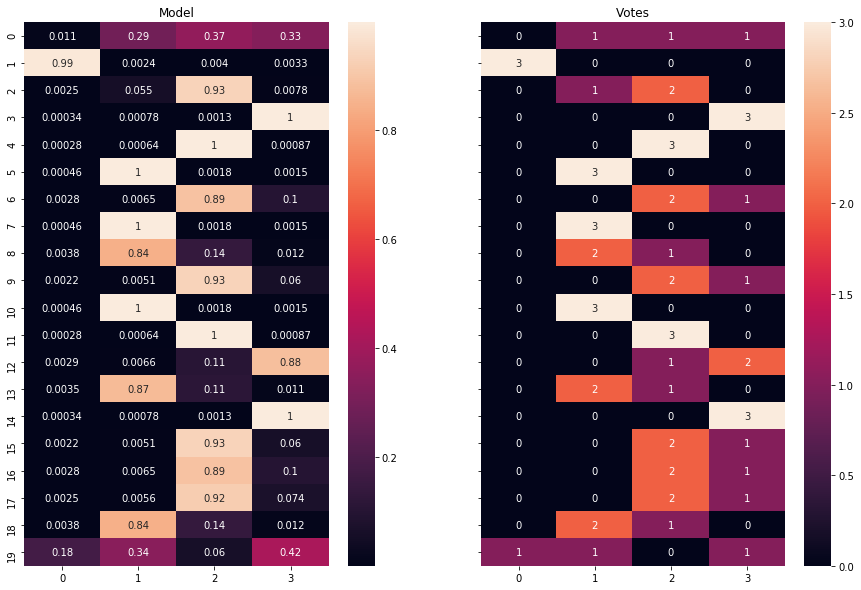

In [182]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [183]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


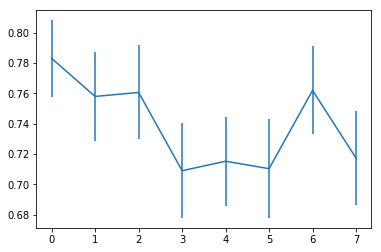

In [184]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [234]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels.shape

(604, 49)

Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [193]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values


And we can visualize all the reviews as a heatmap with the missing values greyed out

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


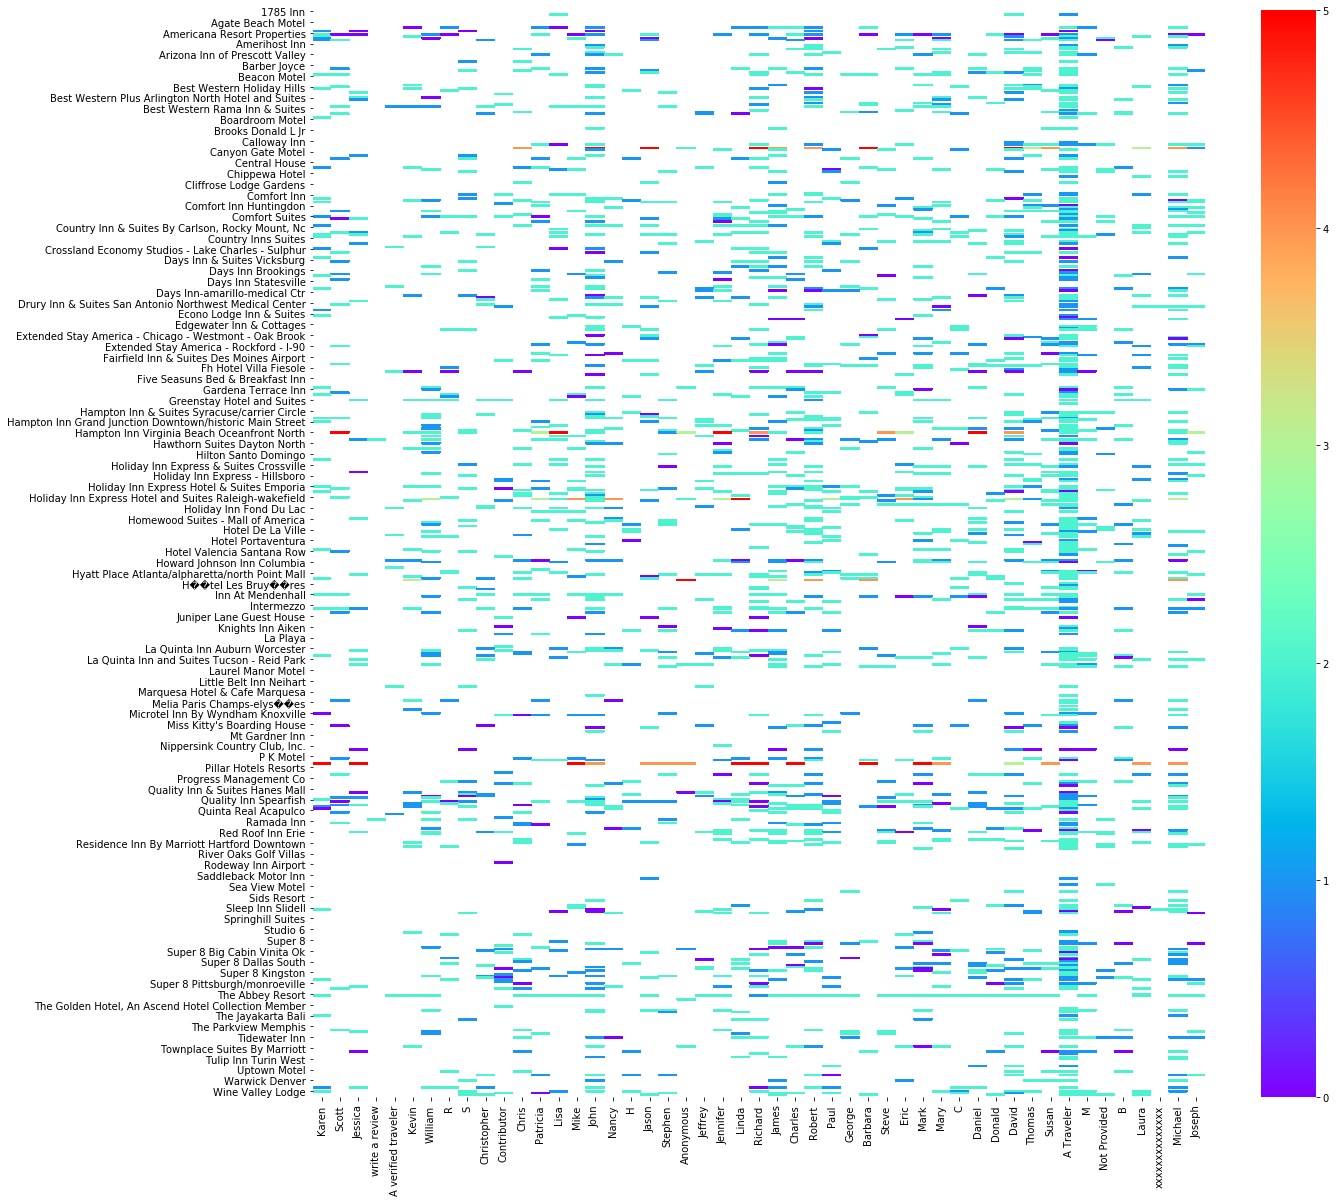

In [187]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [195]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [196]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [197]:
anno_hot.labels

[0.0, 1.0, 2.0]

In [198]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [199]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.34068731, 0.64191769, 0.01739499, 0.        , 0.        ,
       0.        ])

[[0. 1. 0. 0. 0. 0.]
 [1. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


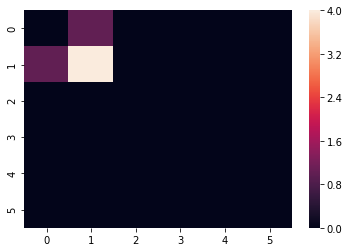

In [200]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [235]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.32489959839357424

In [236]:
krippendorffs_alpha(anno_hot.annotations[::])

0.27530128640008433

In [237]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3564280215550422

//anaconda/lib/python3.5/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


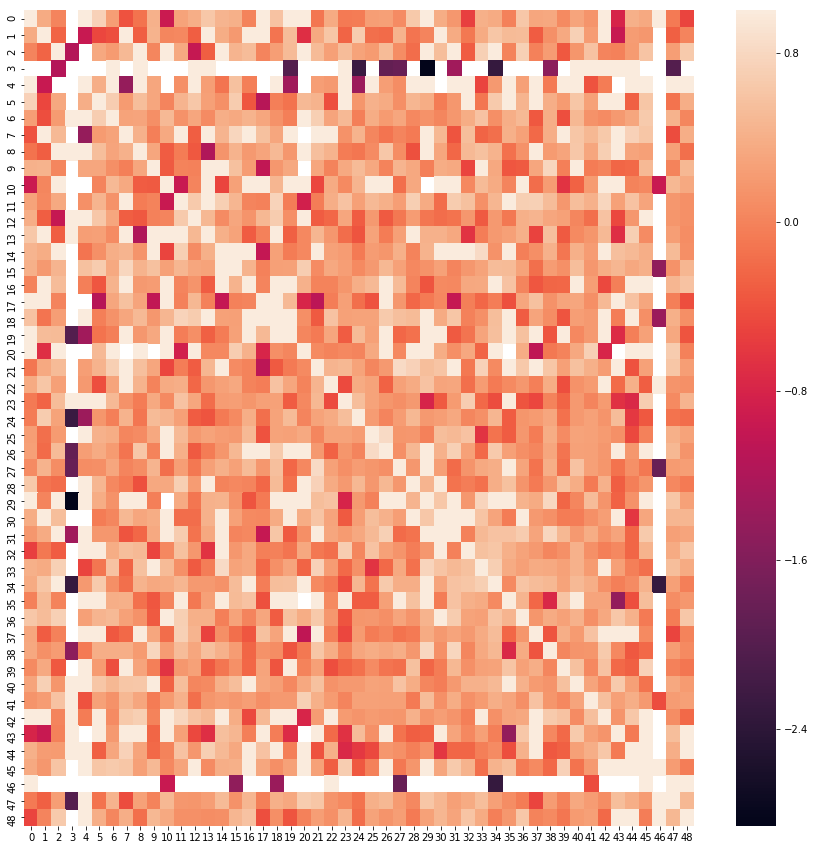

In [238]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [239]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2484.778201399603


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(<matplotlib.figure.Figure at 0x11b8be198>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11ba77048>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11b723b70>))

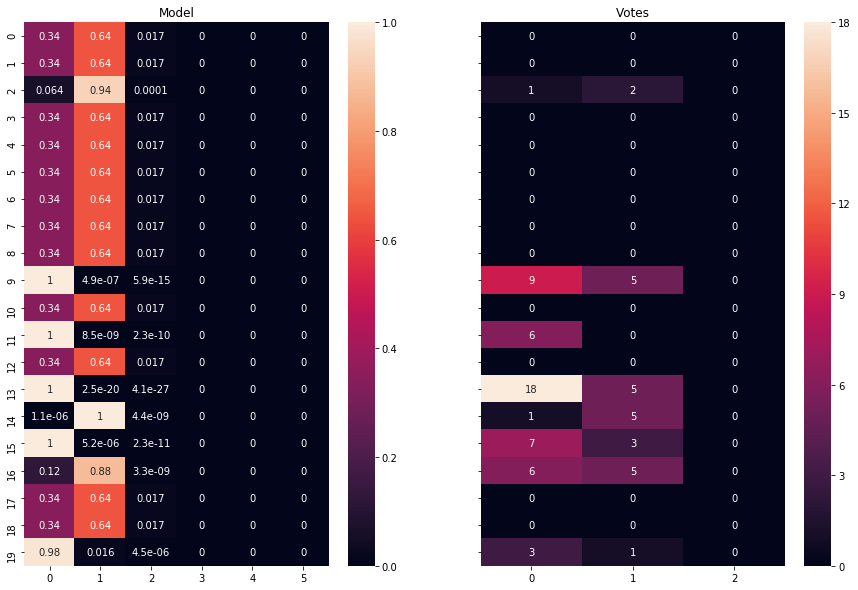

In [240]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [252]:
anno = AnnotationsContainer.from_array(ex_np, missing_values=[-1])

In [285]:
model = ModelBt.create_initial_state(3, 8) #Shiyu: 3 labels + 8 coders?

# other model parameters are initialized from the model prior
#print(model.theta)
print(model.log_likelihood(anno.annotations))

-1077.6970836801183


In [286]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [287]:
model.map(anno.annotations)
#print(model.theta)
print(model.log_likelihood(anno.annotations))
posterior = model.infer_labels(anno.annotations)
print(posterior.shape)

-923.5348405674531
(319, 3)


<span style="color:green">For the block below: I am curious about the prediction of the model. I assign a label to each novel according to the maximum of the probabilities of the 3 labels. 277/319 (87%) of the prediction is correct (modelBt--277 corrects--gives me a better prediction than Model B--236 corrects). It is worth noting that my handing-coding, which has a 91% accuracy rate, was also included in the training model. There is a decrease in accuracy but not much. The model can do better if it gives my votes even more weight. 

In [288]:
posterior = model.infer_labels(anno.annotations)
max_p= posterior.max(axis= 1)
new_cat= []
for i in range(posterior.shape[0]):
    for j in range(posterior.shape[1]):
        p= posterior[i, j]
        if p== max_p[i]:
            new_cat+= [j]
new_cat

real_cat_DF= combined_results["gender"]
real_cat= []
for i in real_cat_DF:
    if i== "male":
        real_cat+= [2]
    else:
        real_cat+= [0]

correct= 0
for i in range(len(new_cat)):
    if new_cat[i]== real_cat[i]:
        correct+= 1

correct

277

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(<matplotlib.figure.Figure at 0x11ba98da0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x115834c88>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1160b74a8>))

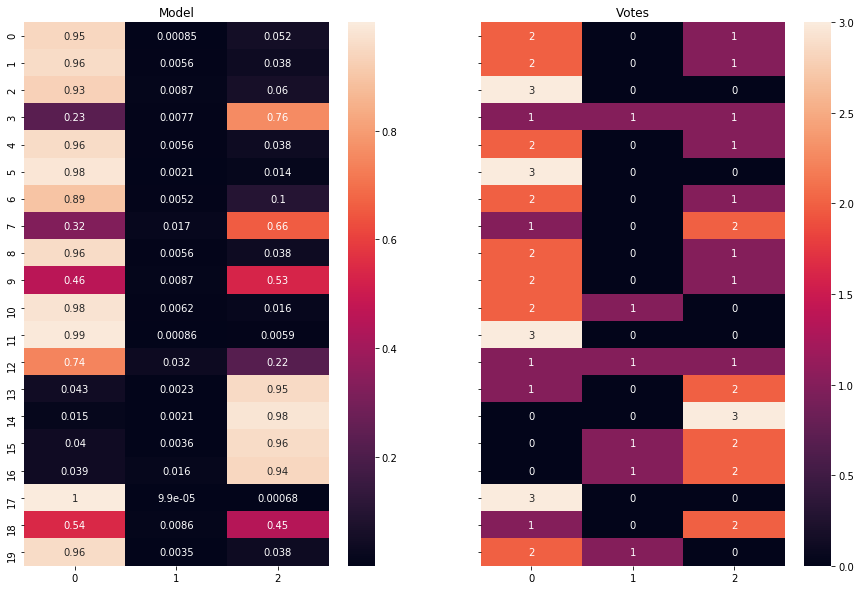

In [289]:
makeQuestionComparison(model, anno, 20)

<span style="color:green"> For the plot below: I am obviously the best worker who has a stable high accuracy rate (I am worker 7, the rightmost one).

<span style="color:green"> The first coder (A2R2YZTSME1K3F) has a high accuracy rate! He/She worked on 65 tasks; this quantity seems trustwhorthy. 

<span style="color:green"> Worker 3 did 305 tasks and worker 6 did 125 tasks. Both of them have very low accuracy rate, espeically worker 6! They cheated my money...

In [290]:
model = ModelBt.create_initial_state(3,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


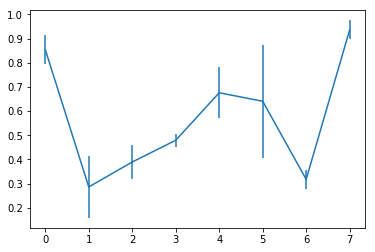

In [291]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()